# Medical Label Project

## Setting up

Import necessary packages and adjust settings.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.options.mode.chained_assignment = None
props = 'background-color : pink;'

Read data from csv files.

In [2]:
reads = pd.read_csv('data/1345_admin_reads.csv')
results = pd.read_csv('data/1345_customer_results.csv',index_col="Case ID")

### Select valid records from the files

The "Origin" column of the result table contains the number of experts who voted on "yes" (out of a total of 8 experts). We would like to extract this information to a separate column of the dataframe.\
To this end, we first throw out all rows which do not contain "voteN" for N=0-8 in the "Origin" column of the results dataframe, and then extract the number N from the column for the remaining data.\
N is the number of experts who voted 'yes'.

In [3]:
valid_vote = results["Origin"].str.fullmatch(r'(.*)vote[0-8](.*)', case=False)
valid_results = results.loc[valid_vote]
votes = valid_results["Origin"].str.extract(r'vote(\d)').astype(int)

### Select useful features

Then we throw out columns that are unnecessary for our analysis in both the read table and the result table. We also create some new columns that will help with our analysis.\
Create a new column to store the number of votes extracted from the "Origin". \
Create a new column to indicate whether the "Majority Label" agrees with the "Correct Label".\
Create a new column to store the accuracy rate of individual expert votes.

In [4]:
reads = reads.loc[:,["problem_id", "user_id", "accuracy","chosen_answer"]]
valid_results = valid_results.loc[:,"Qualified Reads":"Second Choice Weight"]
valid_results["Votes"] = votes
valid_results["Majority Correct"] = valid_results["Majority Label"] == valid_results["Correct Label"]
valid_results["Expert Correct"] = np.max([valid_results["Votes"],8-valid_results["Votes"]],axis=0)/8

After clearing and selecting the data, a sample our dataframe looks like the following.

In [5]:
valid_results.sample(5, random_state=1)

,Qualified Reads,Correct Label,Majority Label,Difficulty,Agreement,First Choice Answer,First Choice Votes,First Choice Weight,Second Choice Answer,Second Choice Votes,Second Choice Weight,Votes,Majority Correct,Expert Correct
Case ID,,,,,,,,,,,,,,
5893135,5,'no','yes',0.800,0.800,'yes',4,3.14,'no',1,0.88,3,False,0.625
5892928,4,'yes','yes',0.250,0.750,'yes',3,2.40,'no',1,0.76,5,True,0.625
5917324,8,NaN,'yes',NaN,0.500,'yes',4,3.06,'no',4,3.10,4,False,0.500
5896492,6,'yes','yes',0.167,0.833,'yes',5,3.94,'no',1,0.78,6,True,0.750
5900598,6,NaN,'no',NaN,1.000,'no',6,4.76,'yes',0,0.00,4,False,0.500


In [6]:
reads.sample(5, random_state=1)

,problem_id,user_id,accuracy,chosen_answer
63015,5901147,172770,0.78,['yes']
85312,5905507,224761,0.82,['no']
48486,5898329,245612,0.84,['no']
950,5888303,245612,0.82,['no']
123176,5913035,245612,0.76,['no']


## Remarks on "Correct Label"

We would like to understand what each column mean and how they are interpreted in our analysis.\
We start by looking at the relation between the correct labels and expert votes.

By interpreting number of votes<4 as having a correct label of 'no', number of votes>4 as having a correct label of 'yes', and having no correct label otherwise, this column completely agrees with the "Correct Label" column.\
This means that our "Correct Label" is determined by the expert majority.

In [7]:
print("Correct Labels corresponding to < 4 votes:", valid_results.loc[valid_results["Votes"]<4,"Correct Label"].unique())
print("Correct Labels corresponding to > 4 votes:", valid_results.loc[valid_results["Votes"]>4,"Correct Label"].unique())
print("Correct Labels corresponding to = 4 votes:", valid_results.loc[valid_results["Votes"]==4,"Correct Label"].unique())

Correct Labels corresponding to < 4 votes: ["'no'"]
Correct Labels corresponding to > 4 votes: ["'yes'"]
Correct Labels corresponding to = 4 votes: [nan]


We also note that out of the 27000 results, 12000 of them have a correct label of 'no', 12000 of them have a correct label of 'yes', and 3000 of them have no correct label.

In [8]:
print(valid_results["Correct Label"].value_counts(dropna=False))

'no'     12000
'yes'    12000
NaN       3000
Name: Correct Label, dtype: int64


## Remark on "Majority Label"

Then we investigate the data on crowd votes.

Out of the 27000 results, 14547 of them have a majority label of 'no', 12211 of them have a majority label of 'yes', and 242 of them have no majority label.

In [9]:
print(valid_results["Majority Label"].value_counts(dropna=False))

'yes'    14547
'no'     12211
NaN        242
Name: Majority Label, dtype: int64


The reason that 242 of them have no majority labels is that all of them have no qualified reads.

In [10]:
print(valid_results.loc[valid_results["Majority Label"].isna(),"Qualified Reads"].value_counts())

0    242
Name: Qualified Reads, dtype: int64


Of the results with at least one qualified reads, 1580 of them have an equal number of yes/no votes. In these cases, the majority label is determined by the sum of accuracy score of qualified reads for each choice answer.

In [11]:
print(valid_results.loc[(valid_results["First Choice Votes"]==valid_results["Second Choice Votes"])&(valid_results["Qualified Reads"]!=0),"Majority Label"].value_counts(dropna=False))

'no'     764
'yes'    744
Name: Majority Label, dtype: int64


To sum up, the majority label is the label given by the majority of the crowd. In the case that there's a tie between two labels, the accuracy score of the labelers are considered to break the tie.

Now that we understand how the majority label and correct label are determined, we can throw out columns that are unnecessary for descriptive analysis. Also, in comparing the crowd label with expert label, we are only interested in cases that are reviewed by at least one labeler (so that there exists a majority label), so we throw out the 242 rows with no majority label. The resulted dataframe is the following.

In [12]:
valid_results=valid_results.loc[~valid_results["Majority Label"].isna(),["Votes", "Correct Label", "Majority Label", "Majority Correct", "Expert Correct", "Qualified Reads", "Difficulty", "Agreement"]]
valid_results.sample(5, random_state=1)

,Votes,Correct Label,Majority Label,Majority Correct,Expert Correct,Qualified Reads,Difficulty,Agreement
Case ID,,,,,,,,
5911362,6,'yes','yes',True,0.750,6,0.0,1.0
5902238,8,'yes','yes',True,1.000,5,0.0,1.0
5903622,5,'yes','yes',True,0.625,2,0.0,1.0
5895844,2,'no','no',True,0.750,4,0.0,1.0
5907907,5,'yes','no',False,0.625,6,1.0,1.0


# Descriptive Analysis
We will try to prove that the crowd agree with the expert majority more often than individual experts agreeing with the expert majority.\
Since our "Correct Label" is determined by the expert majority, it is impossible for the crowd to outperform the expert majority. Thus, we will compare the performance of the crowd with the performance of individual experts, as measured by how often they agree with the correct label.

### Performance Comparison on all Cases

We start by calculating the percentage of with individual experts agrees with the expert majority. Here we only consider cases when there is a correct label./ Overall, individual experts agree with correct label **81.27%** of the time.

In [13]:
np.mean(valid_results.loc[~valid_results["Correct Label"].isna(),"Expert Correct"])

0.8126788871117098

Overall, crowd majority agrees with the correct label **78.61%** of the time.

In [14]:
np.mean(valid_results.loc[~valid_results["Correct Label"].isna(),"Majority Correct"])

0.7861351965653675

From these result we see that the crowd does not outperform the experts overall. But note that the cases in our dataset varies in difficulty. Also, some cases only have a few qualified reads which may not be representative of the "crowd" opinion.\
Thus, we would still like to investigate if there are situations when the crowd outperforms the experts.

### Performance Comparison Grouped By Expert Agreement Rate

Intuitively, if the experts have a high agreement rate (7 or 8 out of 8) on a certain, we expect this case to be an easy case and thus the crowd would agree more with the experts. The following analysis would demonstrate this correlation, and help identify situations when the crowd would outperform individual experts.

We separate the cases into groups according to the agreement rate of the experts on the cases, and look at how crowd performance compares with individual expert in each group. The result is presented in the following table and the visualization of the table. As an example of interpreting this table, the first row would mean: "Among all cases when no expert vote on the 'yes' label, the crowd majority label the cases correctly 89% of the times".

In [15]:
df = valid_results.groupby("Expert Correct")[["Expert Correct",  "Majority Correct"]].mean().loc[0.6:1,:]
df[["Majority Correct"]]

,Majority Correct
Expert Correct,
0.625,0.656050
0.750,0.757341
0.875,0.806018
1.000,0.924693


<AxesSubplot: xlabel='expert accuracy', ylabel='accuracy'>

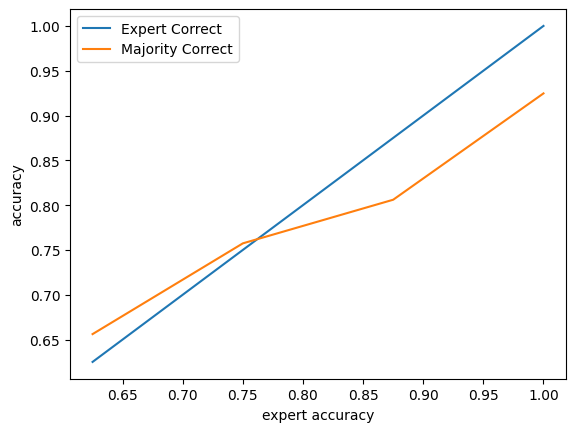

In [16]:
df.plot(ylabel="accuracy", xlabel="expert accuracy")

From the table and the plot, we can reach the following conclusions:
- The crowd accuracy rate is higher for cases when experts have a higher agreement rate.
- The crowd accuracy rate outperform individual experts on cases where experts have a lower agreement rate (5 or 6 out of 8, ie 62.5% - 75%).

Qualitatively, if we restrict our analysis to cases where experts have a low agreement rate ($\leq$ 75%), the crowd performs **2.79%** better than individual experts.

In [17]:
crowd_accuracy = np.mean(valid_results.loc[(~valid_results["Correct Label"].isna()) & (valid_results["Expert Correct"]<0.8),"Majority Correct"])
expert_accuracy = np.mean(valid_results.loc[(~valid_results["Correct Label"].isna()) & (valid_results["Expert Correct"]<0.8),"Expert Correct"])
crowd_accuracy / expert_accuracy - 1

0.02793364609204918

### Performance Comparison Grouped By Number of Qualified Reads

It is noted that for some cases in our dataset, there is very few qualified reads. In these cases, the majority label are more prone to errors of individual labelers and less representative of the crowd opinion. In the following analysis, we will see how the number of qualified reads affects how the accuracy of the crowd compares to the accuracy of individual experts.

We separate all cases to groups according to the number of qualified reads on each case. Then for each group, we calculate the percentage of cases where the crowd majority agrees with the correct label and the percentage of individual experts agrees with the correct label. The result is presented in the following table and the visualization of the table. As an example of interpreting this table, the first row would mean: "Among all cases where there's 1 qualified read, the crowd majority label the cases correctly 62% of the times, while individual experts label the cases correctly 79% of the times".

In [18]:
df = valid_results.loc[~valid_results["Correct Label"].isna(),["Qualified Reads", "Majority Correct","Expert Correct"]].groupby(["Qualified Reads"]).mean()
df

,Majority Correct,Expert Correct
Qualified Reads,,
1,0.621940,0.791818
2,0.678230,0.802432
3,0.738203,0.810017
4,0.754882,0.810648
5,0.812516,0.812391
6,0.833333,0.819753
7,0.879141,0.823028
8,0.889561,0.815904
9,0.900281,0.821805


<AxesSubplot: xlabel='Qualified Reads', ylabel='accuracy'>

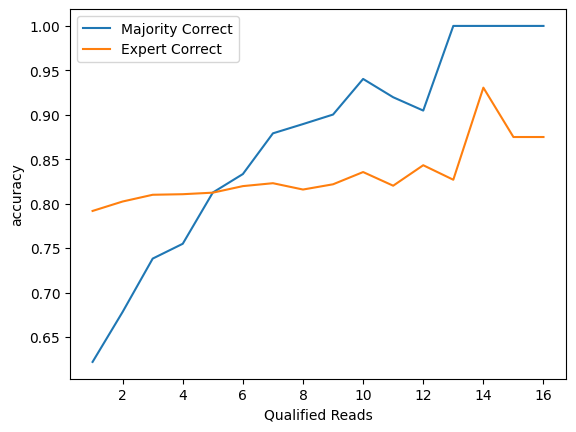

In [19]:
df.plot(ylabel = "accuracy")

We notice a few things from the plot:
- For both the accuracy of the crowd and the experts, the curve is smoother for cases with less than 10 qualified reads and jumps more for cases with more than 10 qualified reads. A possible explanation for this is that there are fewer cases with more than 10 qualified reads.
- The accuracy rate of individual experts is around 0.8 regardless of the number of qualified reads. This make sense because the expert accuracy is independent of the number of qualified reads.
- The accuracy rate of crowd majority tend to be higher for cases with more qualified reads.
- For cases with less than 5 qualified reads, the accuracy rate of the crowd is less than the accuracy rate of individual experts; **For cases with more than 5 qualified reads, the accuracy rate of the crowd is higher than the accuracy rate of individual experts**.

Qualitatively, if we restrict our analysis to cases with more than 5 qualified reads, the crowd performs **5.76%** better than individual experts.

In [20]:
crowd_accuracy = np.mean(valid_results.loc[(~valid_results["Correct Label"].isna()) & (valid_results["Qualified Reads"]>5),"Majority Correct"])
expert_accuracy = np.mean(valid_results.loc[(~valid_results["Correct Label"].isna()) & (valid_results["Qualified Reads"]>5),"Expert Correct"])
crowd_accuracy / expert_accuracy - 1

0.05759063086281713

### Performance Comparison Grouped By Both Factors

From previous sections, we know that crowd outperforms individual experts on cases with *less agreement among experts* and *more qualified reads*. Now we combine these two factors and have a closer look at the subcases.

The following table shows the accuracy rate of the crowd on cases with a specific number of qualified reads (for each row) and a specific expert agreement rate (for each column). An example of interpreting this table is: "Among all cases where there are 5 qualified read and where expert agreement rate is 75%, the crowd majority label the cases correctly 78% of the times."

In this table, higher crowd accuracy rate is shown in deeper color. We can see the trend of the accuracy being higher with the increase in both the expert agreement rate and the number of qualified reads. The crowd accuracy is highlighted in pink if it is higher than the accuracy of individual experts. The black cells indicate that there's no such cases.

In [21]:
df = valid_results.loc[~valid_results["Correct Label"].isna(),["Qualified Reads", "Majority Correct","Expert Correct"]].groupby(["Qualified Reads","Expert Correct"]).mean()
df = df.unstack()

In [22]:
df.style.text_gradient(low=0.5)\
        .applymap(lambda x: props if x>=0.625 else None, subset=[df.columns[0]])\
        .applymap(lambda x: props if x>=0.75 else None, subset=[df.columns[1]])\
        .applymap(lambda x: props if x>=0.875 else None, subset=[df.columns[2]])\
        .applymap(lambda x: props if x>=1 else None, subset=[df.columns[3]])\
        .highlight_null('Black')

The pink cells are clustered in the lower left corner, which are cases with more qualified reads and less agreement among experts. Thus, we conclude based on this table that **crowd outperforms individual experts on cases where the expert agreement rate is at most 75% and the number of qualified reads is more than 5, and for cases there the expert agreement rate is 87.5%, the crowd outperform individual expert if there are at least 7 qualified reads**.

### Was the crowd more certain than experts?

In the following table, we calculated the mean agreement rate of the crowd among themselves and with the experts, grouped by the agreement rate among experts. The first column is the agreement rate among crowd, the last is the agreement among experts.

In [23]:
agreement_df = valid_results.groupby("Votes")[["Agreement", "Expert Correct"]].mean()
agreement_df.rename(columns={"Agreement":"Crowd Agreement", "Expert Correct":"Expert Agreement"},inplace=True)
agreement_df

,Crowd Agreement,Expert Agreement
Votes,,
0,0.918691,1.000
1,0.868989,0.875
2,0.860767,0.750
3,0.862261,0.625
4,0.826883,0.500
5,0.856689,0.625
6,0.889775,0.750
7,0.903458,0.875
8,0.943650,1.000


The plot below provides a visualization of the previous table. As we can see in the plot, the agreement rate among the crowd is high regardless of the expert agreement rate. This is especially interesting for cases where the agreement rate among experts is low (Votes=4). It means that for cases when experts agree only 50% of the times among themselves, the crowd is agreeing 82% of the times. Thus, the crowd shows a much higher certainty on cases where experts are less certain.

<AxesSubplot: xlabel='Votes'>

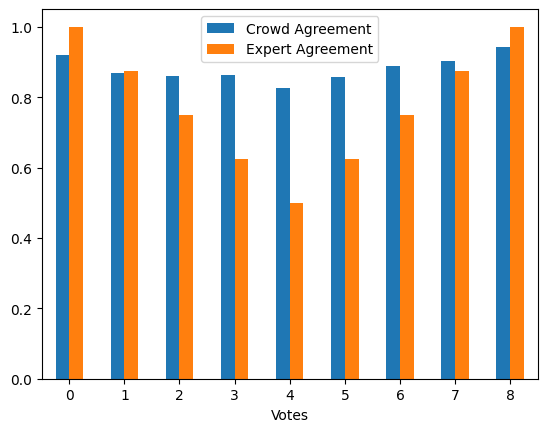

In [24]:
agreement_df.plot.bar(rot=0)

## Conclusion

To summarize our analysis:
- For cases where experts have high agreement rate, the crowd also agrees more with the correct label.
- As the number of qualified reads increases, the accuracy of the label given by the crowd increases.
- For cases with more than 5 qualified reads, the crowd are more likely to agree with expert majority than individual expert does.
- The crowd opinion is highly unified regardless of how unified the experts are on cases.